# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Sat Apr  8 17:53:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 30%   41C    P8    24W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:49:00.0 Off |                  N/A |
| 30%   

# Download and import required packages

In [2]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 7.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.1/757.1 kB 7.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 17.0 MB/s eta 0:00:0000:0100:01
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 1.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 2.2 MB/s eta 0:

In [3]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 34540, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 34540 (delta 0), reused 3 (delta 0), pack-reused 34534
Receiving objects: 100% (34540/34540), 24.06 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (25109/25109), done.
Updating files: 100% (1575/1575), done.
Note: switching to '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Process

In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [2]:
seed = 14515123
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* TED2020
    - Raw: 400,726 (sentences)   
    - Processed: 394,052 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [3]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.data.tgz",
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.test.tgz"
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## Language

In [4]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [5]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [6]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [7]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [8]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [9]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [10]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [11]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [12]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/frankchiang/cource/ml/hw5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [13]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq
Prepare the files in pairs for both the source and target languages. \\
In case a pair is unavailable, generate a pseudo pair to facilitate binarization.

In [14]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [15]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=64, #num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=256,
    accum_steps=4, #accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=1.5, #lr_factor=2.,
    lr_warmup=12000, #lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0, #clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=150000, #max_epoch=15,
    start_epoch=1,
    early_stop=40, ##
    
    # beam size for beam search
    beam=16, #beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.5, #max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [16]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [17]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-04-13 05:06:02 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-04-13 05:06:02 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.696 GB ; name = NVIDIA GeForce RTX 3090                 
2023-04-13 05:06:02 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [18]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-04-13 05:06:03 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2023-04-13 05:06:03 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [19]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-04-13 05:06:03 | INFO | hw5.seq2seq | loading data for epoch 1
2023-04-13 05:06:03 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2023-04-13 05:06:03 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2023-04-13 05:06:03 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390112 examples
2023-04-13 05:06:03 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2023-04-13 05:06:03 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2023-04-13 05:06:03 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3940 examples


In [20]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  24,   63,    5,   90, 1323,  143,  140,  184,  281,   37,    8,   81,
         254,   11,   80,   55,   12,  376,   20,  155,   60, 1007,   98,  587,
          76,  256,    6,   98, 1465,    7,    2]),
 'target': tensor([ 162,  116, 3756,  364,  158, 3055, 2925,    9, 2547,    4,  596,  123,
        1518,  455,  667,   64,  406,  566,   74, 1908, 3790,  191,   10,    2])}
('Source: you can throw out crazy theories and not have to back it up with '
 'data or graphs or research .')
'Target: 你能拋開這些瘋狂的理論 , 不用數據圖表、或研究來支撐它 。'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [21]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-04-13 05:06:04 | WARNING | fairseq.tasks.fairseq_task | 2,494 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1856, 2936, 3373, 3863, 918, 3540, 1246, 1791, 1790, 3250]


{'id': tensor([2593]),
 'nsentences': 1,
 'ntokens': 11,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,   20,   14,    6,    8,  421,   16,
             24,   18,  833,   38,    6,    4,  227,    4,   39, 2272,    7,    2]]),
  'src_lengths': tensor([18]),
  'prev_output_tokens': tensor([[   2,  142,  372,   29,  120,   65, 3050,    9, 3496, 1252,   10,    1,
              1,    1,    1,    1]])},
 'target': tensor([[ 142,  372,   29,  120,   65, 3050,    9, 3496, 1252,   10,    2,    1,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [22]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [23]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [25]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [26]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [27]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    # encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [28]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2023-04-13 05:06:10 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 512, dropout=0.3, bidirectional=True)
    (dropout_out_module): Dropout(p=0.3, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (dropout_out_module): Dropout(p=0.3, inplace=False)
    (project_out_dim): Linear(in_features=1024, out_features=256, bias=True)
    (output_projection): Linear(in_features=256, out_features=7992, bias=False)
  )
)


/home/frankchiang/local/anaconda3/envs/ml2023_hw5/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [31]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [32]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    #lr = 0.001
    lr = (d_model**-0.5) * min(step_num**-0.5, step_num*(warmup_step**-1.5))
    return lr

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

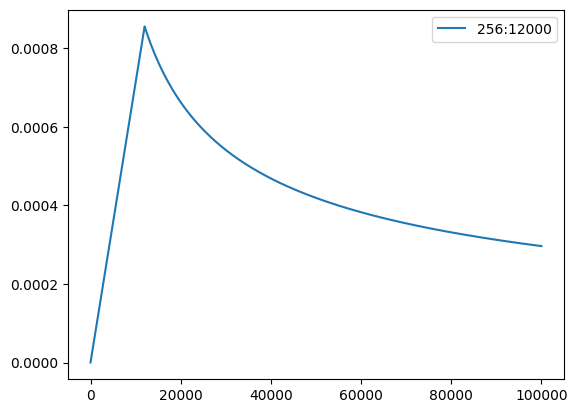

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [35]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [36]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [37]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [38]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True, bad_count=0):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            bad_count = 0
        else:
            bad_count += 1
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats, bad_count

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-04-13 05:06:26 | INFO | hw5.seq2seq | task: TranslationTask
2023-04-13 05:06:26 | INFO | hw5.seq2seq | encoder: RNNEncoder
2023-04-13 05:06:26 | INFO | hw5.seq2seq | decoder: RNNDecoder
2023-04-13 05:06:26 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-04-13 05:06:26 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-04-13 05:06:26 | INFO | hw5.seq2seq | num. model params: 11,247,872 (num. trained: 11,247,872)
2023-04-13 05:06:26 | INFO | hw5.seq2seq | max tokens per batch = 256, accumulate steps = 4


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
bad_count = 0
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats, bad_count = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch, bad_count=bad_count)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)
    if (bad_count >= config.early_stop):
        break

2023-04-13 05:06:26 | WARNING | fairseq.tasks.fairseq_task | 99 samples have invalid sizes and will be skipped, max_positions=(256, 256), first few sample ids=[88282, 382624, 365306, 238657, 79845, 78526, 124051, 61324, 308615, 297444]
2023-04-13 05:06:27 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=1210856 loss=3.936180830001831 bleu=18.895392817451942


train epoch 1:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 05:14:44 | INFO | hw5.seq2seq | training loss: 3.9209
2023-04-13 05:14:44 | INFO | hw5.seq2seq | begin validation
2023-04-13 05:14:44 | WARNING | fairseq.tasks.fairseq_task | 2 samples have invalid sizes and will be skipped, max_positions=(256, 256), first few sample ids=[1645, 1224]


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 05:15:31 | INFO | hw5.seq2seq | example source: there are actually two tails .
2023-04-13 05:15:31 | INFO | hw5.seq2seq | example hypothesis: 其實有兩個尾巴 。
2023-04-13 05:15:31 | INFO | hw5.seq2seq | example reference: 慧尾其實有兩條 。
2023-04-13 05:15:31 | INFO | hw5.seq2seq | validation loss:	3.9415
2023-04-13 05:15:31 | INFO | hw5.seq2seq | BLEU = 18.77 52.5/27.2/15.2/8.9 (BP = 0.894 ratio = 0.900 hyp_len = 98700 ref_len = 109719)
2023-04-13 05:15:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint1.pt
2023-04-13 05:15:32 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 05:23:46 | INFO | hw5.seq2seq | training loss: 3.9186
2023-04-13 05:23:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 05:24:34 | INFO | hw5.seq2seq | example source: that was the future , right ?
2023-04-13 05:24:34 | INFO | hw5.seq2seq | example hypothesis: 這是未來 , 對吧 ?
2023-04-13 05:24:34 | INFO | hw5.seq2seq | example reference: 但那就是未來 , 對吧 ?
2023-04-13 05:24:34 | INFO | hw5.seq2seq | validation loss:	3.9427
2023-04-13 05:24:34 | INFO | hw5.seq2seq | BLEU = 18.67 51.7/26.5/14.7/8.6 (BP = 0.915 ratio = 0.919 hyp_len = 100808 ref_len = 109719)
2023-04-13 05:24:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint2.pt
2023-04-13 05:24:35 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 05:32:50 | INFO | hw5.seq2seq | training loss: 3.9187
2023-04-13 05:32:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 05:33:38 | INFO | hw5.seq2seq | example source: uber and didi use crowdsource for driving .
2023-04-13 05:33:38 | INFO | hw5.seq2seq | example hypothesis: uber和i使用群眾來源開車 。
2023-04-13 05:33:38 | INFO | hw5.seq2seq | example reference: uber和didi用群眾外包做駕駛 ,
2023-04-13 05:33:38 | INFO | hw5.seq2seq | validation loss:	3.9400
2023-04-13 05:33:38 | INFO | hw5.seq2seq | BLEU = 18.89 51.7/26.6/14.8/8.7 (BP = 0.922 ratio = 0.925 hyp_len = 101488 ref_len = 109719)
2023-04-13 05:33:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint3.pt
2023-04-13 05:33:39 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 05:41:54 | INFO | hw5.seq2seq | training loss: 3.9194
2023-04-13 05:41:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 05:42:43 | INFO | hw5.seq2seq | example source: i know .
2023-04-13 05:42:43 | INFO | hw5.seq2seq | example hypothesis: 我知道 。
2023-04-13 05:42:43 | INFO | hw5.seq2seq | example reference: 我知道 。
2023-04-13 05:42:43 | INFO | hw5.seq2seq | validation loss:	3.9413
2023-04-13 05:42:43 | INFO | hw5.seq2seq | BLEU = 18.90 51.9/26.8/14.9/8.7 (BP = 0.916 ratio = 0.919 hyp_len = 100824 ref_len = 109719)
2023-04-13 05:42:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint4.pt
2023-04-13 05:42:44 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 05:50:58 | INFO | hw5.seq2seq | training loss: 3.9194
2023-04-13 05:50:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 05:51:48 | INFO | hw5.seq2seq | example source: this is the house where the shooting took place .
2023-04-13 05:51:48 | INFO | hw5.seq2seq | example hypothesis: 這是房子拍攝的房子 。
2023-04-13 05:51:48 | INFO | hw5.seq2seq | example reference: 這是槍擊案地點的房子 。
2023-04-13 05:51:48 | INFO | hw5.seq2seq | validation loss:	3.9385
2023-04-13 05:51:48 | INFO | hw5.seq2seq | BLEU = 19.01 51.2/26.3/14.7/8.6 (BP = 0.936 ratio = 0.938 hyp_len = 102897 ref_len = 109719)
2023-04-13 05:51:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint5.pt
2023-04-13 05:51:49 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:00:03 | INFO | hw5.seq2seq | training loss: 3.9195
2023-04-13 06:00:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:00:51 | INFO | hw5.seq2seq | example source: here is the thing .
2023-04-13 06:00:51 | INFO | hw5.seq2seq | example hypothesis: 重點是:
2023-04-13 06:00:51 | INFO | hw5.seq2seq | example reference: 因為
2023-04-13 06:00:51 | INFO | hw5.seq2seq | validation loss:	3.9396
2023-04-13 06:00:51 | INFO | hw5.seq2seq | BLEU = 18.71 52.2/26.8/14.9/8.7 (BP = 0.908 ratio = 0.912 hyp_len = 100072 ref_len = 109719)
2023-04-13 06:00:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint6.pt
2023-04-13 06:00:51 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:09:07 | INFO | hw5.seq2seq | training loss: 3.9186
2023-04-13 06:09:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:09:55 | INFO | hw5.seq2seq | example source: and the only way that mathematicians know how to model this structure is with crochet . it happens to be a fact .
2023-04-13 06:09:55 | INFO | hw5.seq2seq | example hypothesis: 數學家們知道如何模擬這個結構的結構 。 它真的會發生 。
2023-04-13 06:09:55 | INFO | hw5.seq2seq | example reference: 也是數學家認為唯一能展現此幾何的方式就是針織這是個事實
2023-04-13 06:09:55 | INFO | hw5.seq2seq | validation loss:	3.9387
2023-04-13 06:09:55 | INFO | hw5.seq2seq | BLEU = 18.99 51.7/26.5/14.7/8.6 (BP = 0.931 ratio = 0.933 hyp_len = 102379 ref_len = 109719)
2023-04-13 06:09:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint7.pt
2023-04-13 06:09:56 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:18:13 | INFO | hw5.seq2seq | training loss: 3.9185
2023-04-13 06:18:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:19:01 | INFO | hw5.seq2seq | example source: kb: where are we ? where are we ?
2023-04-13 06:19:01 | INFO | hw5.seq2seq | example hypothesis: kb:我們在哪裡 ? 我們在哪 ?
2023-04-13 06:19:01 | INFO | hw5.seq2seq | example reference: kb:我們在哪 ? 我們在哪 ?
2023-04-13 06:19:01 | INFO | hw5.seq2seq | validation loss:	3.9408
2023-04-13 06:19:01 | INFO | hw5.seq2seq | BLEU = 19.05 52.0/26.9/15.0/8.8 (BP = 0.918 ratio = 0.922 hyp_len = 101118 ref_len = 109719)
2023-04-13 06:19:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint8.pt
2023-04-13 06:19:03 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:27:17 | INFO | hw5.seq2seq | training loss: 3.9195
2023-04-13 06:27:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:28:07 | INFO | hw5.seq2seq | example source: [without humor we are all dead] whatever one thought of that satirical magazine , however one felt about those particular cartoons , we all sensed that something fundamental was at stake , that citizens of free societies actually , citizens of any society need humor as much as the air we breathe .
2023-04-13 06:28:07 | INFO | hw5.seq2seq | example hypothesis: 無論我們所謂的 「 無論 」 是什麼 , 對於這些特殊的漫畫 , 我們都知道 , 所有社會的幽默 , 都被認為是無所謂的 , 公民社會需要幽默的公民 , 對於那些特別的漫畫 , 我們都知道 , 所有社會需要幽默的公民 , 像是我們所謂的公民社會的需求 。
2023-04-13 06:28:07 | INFO | hw5.seq2seq | example reference: 〔沒有幽默 , 我們都等於死了〕不論大家對那諷刺雜誌有什麼看法 , 不論大家對那些漫畫有什麼樣的感受 , 我們都能感覺到 , 有某種很根本的東西在危急關頭 , 自由社會的公民 , 甚或任何社會的公民 , 需要幽默就如同需要呼吸空氣一樣 。
2023-04-13 06:28:07 | INFO | hw5.seq2seq | validation loss:	3.9382
2023-04-13 06:28:07 | INFO | hw5.seq2seq | BLEU = 19.09 50.9/26.1/14.5/8.5 (BP = 0.950 ratio = 0.952 hyp_len = 104402 ref_len = 109719)
2023-04-13 06:28:08 | INFO | hw5.seq2seq | saved epoch checkpoint:

train epoch 10:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:36:23 | INFO | hw5.seq2seq | training loss: 3.9192
2023-04-13 06:36:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:37:11 | INFO | hw5.seq2seq | example source: i would change depending on the places i would go the title of the exhibition .
2023-04-13 06:37:11 | INFO | hw5.seq2seq | example hypothesis: 我將改變取決於我所展現的展覽中 。
2023-04-13 06:37:11 | INFO | hw5.seq2seq | example reference: 我會改變---我的創作隨著旅行的地方、畫展的主題而改變 。
2023-04-13 06:37:11 | INFO | hw5.seq2seq | validation loss:	3.9381
2023-04-13 06:37:11 | INFO | hw5.seq2seq | BLEU = 18.88 52.0/26.7/14.8/8.7 (BP = 0.919 ratio = 0.922 hyp_len = 101160 ref_len = 109719)
2023-04-13 06:37:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint10.pt
2023-04-13 06:37:12 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:45:27 | INFO | hw5.seq2seq | training loss: 3.9191
2023-04-13 06:45:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:46:15 | INFO | hw5.seq2seq | example source: and even though , through his peripheral vision , he can see that he's in this lab space , he should be able to see that he's not actually on the street , but he feels like he's there with those people .
2023-04-13 06:46:15 | INFO | hw5.seq2seq | example hypothesis: 儘管如此 , 在這個實驗室空間裡 , 他可以看見他在這個實驗室空間裡 , 但他覺得自己和那些人一樣 。
2023-04-13 06:46:15 | INFO | hw5.seq2seq | example reference: 然而即便藉由他的餘光他能夠看出他是在實驗室裡 , 他應該能夠看出他根本不在街上 , 但是他感覺自己好像和那些人一起在那邊一樣 ,
2023-04-13 06:46:15 | INFO | hw5.seq2seq | validation loss:	3.9414
2023-04-13 06:46:15 | INFO | hw5.seq2seq | BLEU = 18.94 51.9/26.8/14.9/8.7 (BP = 0.918 ratio = 0.921 hyp_len = 101081 ref_len = 109719)
2023-04-13 06:46:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint11.pt
2023-04-13 06:46:16 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 06:54:32 | INFO | hw5.seq2seq | training loss: 3.9193
2023-04-13 06:54:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 06:55:20 | INFO | hw5.seq2seq | example source: just quickly on the results .
2023-04-13 06:55:20 | INFO | hw5.seq2seq | example hypothesis: 簡單地說明一下結果 。
2023-04-13 06:55:20 | INFO | hw5.seq2seq | example reference: 很快說明我們的結果 。
2023-04-13 06:55:20 | INFO | hw5.seq2seq | validation loss:	3.9408
2023-04-13 06:55:20 | INFO | hw5.seq2seq | BLEU = 18.89 52.4/27.2/15.2/9.0 (BP = 0.900 ratio = 0.905 hyp_len = 99300 ref_len = 109719)
2023-04-13 06:55:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint12.pt
2023-04-13 06:55:21 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:03:36 | INFO | hw5.seq2seq | training loss: 3.9197
2023-04-13 07:03:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:04:24 | INFO | hw5.seq2seq | example source: it's called color .
2023-04-13 07:04:24 | INFO | hw5.seq2seq | example hypothesis: 它叫做顏色 。
2023-04-13 07:04:24 | INFO | hw5.seq2seq | example reference: 它叫做顏色 。
2023-04-13 07:04:24 | INFO | hw5.seq2seq | validation loss:	3.9398
2023-04-13 07:04:24 | INFO | hw5.seq2seq | BLEU = 19.12 51.9/26.9/15.0/8.8 (BP = 0.923 ratio = 0.926 hyp_len = 101593 ref_len = 109719)
2023-04-13 07:04:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint13.pt
2023-04-13 07:04:26 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:12:41 | INFO | hw5.seq2seq | training loss: 3.9196
2023-04-13 07:12:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:13:30 | INFO | hw5.seq2seq | example source: this is a calf in captivity making an imitation of that trainer's whistle .
2023-04-13 07:13:30 | INFO | hw5.seq2seq | example hypothesis: 這是一個微小的模仿 , 捕捉到訓練者的模仿 。
2023-04-13 07:13:30 | INFO | hw5.seq2seq | example reference: 這是一隻人工飼養的小海豚模仿的教練的哨聲
2023-04-13 07:13:30 | INFO | hw5.seq2seq | validation loss:	3.9425
2023-04-13 07:13:30 | INFO | hw5.seq2seq | BLEU = 19.04 51.4/26.4/14.7/8.6 (BP = 0.935 ratio = 0.937 hyp_len = 102791 ref_len = 109719)
2023-04-13 07:13:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint14.pt
2023-04-13 07:13:30 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:21:47 | INFO | hw5.seq2seq | training loss: 3.9192
2023-04-13 07:21:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:22:34 | INFO | hw5.seq2seq | example source: so if the museum in toronto went out and collected a tyrannosaur , a big one , then the museum in ottawa wanted a bigger one , and a better one .
2023-04-13 07:22:34 | INFO | hw5.seq2seq | example hypothesis: 所以 , 如果博物館的博物館在加拿大的博物館 , 去找更多的博物館 , 大部份的博物館 , 就會更美好 。
2023-04-13 07:22:34 | INFO | hw5.seq2seq | example reference: 所以如果多倫多的博物館蒐集到一副暴龍的骸骨 , 大隻的暴龍那麼渥太華的博物館就想要一隻更大更好的暴龍
2023-04-13 07:22:34 | INFO | hw5.seq2seq | validation loss:	3.9442
2023-04-13 07:22:34 | INFO | hw5.seq2seq | BLEU = 18.83 52.2/26.9/15.0/8.7 (BP = 0.909 ratio = 0.913 hyp_len = 100175 ref_len = 109719)
2023-04-13 07:22:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint15.pt
2023-04-13 07:22:35 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:30:50 | INFO | hw5.seq2seq | training loss: 3.9197
2023-04-13 07:30:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:31:38 | INFO | hw5.seq2seq | example source: so what does that mean ?
2023-04-13 07:31:38 | INFO | hw5.seq2seq | example hypothesis: 那是什麼意思 ?
2023-04-13 07:31:38 | INFO | hw5.seq2seq | example reference: 這意味著什麼 ?
2023-04-13 07:31:38 | INFO | hw5.seq2seq | validation loss:	3.9430
2023-04-13 07:31:38 | INFO | hw5.seq2seq | BLEU = 18.78 52.1/26.8/14.9/8.7 (BP = 0.909 ratio = 0.913 hyp_len = 100129 ref_len = 109719)
2023-04-13 07:31:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint16.pt
2023-04-13 07:31:38 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:39:52 | INFO | hw5.seq2seq | training loss: 3.9196
2023-04-13 07:39:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:40:40 | INFO | hw5.seq2seq | example source: on the floor , a stylized compass gave the direction to each immigration detention center , accompanied by the distance and the name of the immigration facility .
2023-04-13 07:40:40 | INFO | hw5.seq2seq | example hypothesis: 在地板上 , 身為移民機構的每個移民中心 , 都被距離和移民中心的距離給移民 。
2023-04-13 07:40:40 | INFO | hw5.seq2seq | example reference: 底部有一個特製的指南針 , 指向每一個移民拘留中心 , 同時顯示出距離和移民署的名字 。
2023-04-13 07:40:40 | INFO | hw5.seq2seq | validation loss:	3.9433
2023-04-13 07:40:40 | INFO | hw5.seq2seq | BLEU = 18.73 51.9/26.7/14.8/8.6 (BP = 0.912 ratio = 0.916 hyp_len = 100492 ref_len = 109719)
2023-04-13 07:40:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint17.pt
2023-04-13 07:40:41 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:48:56 | INFO | hw5.seq2seq | training loss: 3.9194
2023-04-13 07:48:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:49:44 | INFO | hw5.seq2seq | example source: generally , it's kind of a fuzzy threedimensional geometry .
2023-04-13 07:49:44 | INFO | hw5.seq2seq | example hypothesis: 一般來說 , 這是一個令人難以置信的三維空間 。
2023-04-13 07:49:44 | INFO | hw5.seq2seq | example reference: 總而言之 , 這是一個模糊的三維幾何世界 。
2023-04-13 07:49:44 | INFO | hw5.seq2seq | validation loss:	3.9442
2023-04-13 07:49:44 | INFO | hw5.seq2seq | BLEU = 18.86 51.9/26.7/14.8/8.7 (BP = 0.917 ratio = 0.921 hyp_len = 101002 ref_len = 109719)
2023-04-13 07:49:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint18.pt
2023-04-13 07:49:45 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 07:58:02 | INFO | hw5.seq2seq | training loss: 3.9187
2023-04-13 07:58:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 07:58:50 | INFO | hw5.seq2seq | example source: when the visual cortex is deprived of input from the eyes , even temporarily , the brain still tries to create a coherent picture , but the limits of its abilities become a lot more obvious .
2023-04-13 07:58:50 | INFO | hw5.seq2seq | example hypothesis: 當視覺皮質在視覺皮層下降低時 , 大腦仍然會試著建立一個相似的圖表 , 但它的限制很明顯 。
2023-04-13 07:58:50 | INFO | hw5.seq2seq | example reference: 當視覺皮層得不到來自眼睛的輸入資料時 , 即使只有一下下 , 大腦仍然會試圖創造出一個協調連貫的圖像 , 但就能很明顯發現 , 它的能力有限 。
2023-04-13 07:58:50 | INFO | hw5.seq2seq | validation loss:	3.9449
2023-04-13 07:58:50 | INFO | hw5.seq2seq | BLEU = 18.89 51.7/26.6/14.8/8.6 (BP = 0.924 ratio = 0.927 hyp_len = 101706 ref_len = 109719)
2023-04-13 07:58:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint19.pt
2023-04-13 07:58:51 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:07:06 | INFO | hw5.seq2seq | training loss: 3.9181
2023-04-13 08:07:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:07:53 | INFO | hw5.seq2seq | example source: in the u . s . only one percent of the people are actually farmers .
2023-04-13 08:07:53 | INFO | hw5.seq2seq | example hypothesis: 在美國 , 只有1%的人是農夫 。
2023-04-13 08:07:53 | INFO | hw5.seq2seq | example reference: 美國則只有百分之一的人口務農 。
2023-04-13 08:07:53 | INFO | hw5.seq2seq | validation loss:	3.9432
2023-04-13 08:07:53 | INFO | hw5.seq2seq | BLEU = 18.86 52.1/26.9/15.0/8.8 (BP = 0.909 ratio = 0.913 hyp_len = 100185 ref_len = 109719)
2023-04-13 08:07:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint20.pt
2023-04-13 08:07:54 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:16:07 | INFO | hw5.seq2seq | training loss: 3.9182
2023-04-13 08:16:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:16:56 | INFO | hw5.seq2seq | example source: and this is absolutely crucial to the monotheisms , too .
2023-04-13 08:16:56 | INFO | hw5.seq2seq | example hypothesis: 這絕對是對恐怖主義也很重要 。
2023-04-13 08:16:56 | INFO | hw5.seq2seq | example reference: 這對於一神論者來說也是重要的
2023-04-13 08:16:56 | INFO | hw5.seq2seq | validation loss:	3.9424
2023-04-13 08:16:56 | INFO | hw5.seq2seq | BLEU = 18.76 51.2/26.2/14.5/8.4 (BP = 0.933 ratio = 0.935 hyp_len = 102606 ref_len = 109719)
2023-04-13 08:16:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint21.pt
2023-04-13 08:16:57 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:25:12 | INFO | hw5.seq2seq | training loss: 3.9182
2023-04-13 08:25:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:26:00 | INFO | hw5.seq2seq | example source: institutions only have two tools: carrots and sticks .
2023-04-13 08:26:00 | INFO | hw5.seq2seq | example hypothesis: 機構只有兩個工具:木材和黏土 。
2023-04-13 08:26:00 | INFO | hw5.seq2seq | example reference: 機構只有兩種工具:胡蘿蔔跟棍子 。
2023-04-13 08:26:00 | INFO | hw5.seq2seq | validation loss:	3.9440
2023-04-13 08:26:00 | INFO | hw5.seq2seq | BLEU = 18.82 51.4/26.3/14.6/8.5 (BP = 0.929 ratio = 0.932 hyp_len = 102241 ref_len = 109719)
2023-04-13 08:26:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint22.pt
2023-04-13 08:26:01 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:34:16 | INFO | hw5.seq2seq | training loss: 3.9171
2023-04-13 08:34:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:35:04 | INFO | hw5.seq2seq | example source: hydrogen atoms smash together to form helium , accompanied by a great release of energy , strong enough to counteract the shrinking force of the gravity .
2023-04-13 08:35:04 | INFO | hw5.seq2seq | example hypothesis: 氫原子會被釋放能量強大的能量 , 結合 , 結合了所有能量的強點 , 結合了大量的能量 。
2023-04-13 08:35:04 | INFO | hw5.seq2seq | example reference: 氫原子融合為氦同時釋放巨大能量大得可對抗向內拉扯的引力
2023-04-13 08:35:04 | INFO | hw5.seq2seq | validation loss:	3.9447
2023-04-13 08:35:04 | INFO | hw5.seq2seq | BLEU = 18.99 51.9/26.8/15.0/8.9 (BP = 0.916 ratio = 0.920 hyp_len = 100888 ref_len = 109719)
2023-04-13 08:35:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint23.pt
2023-04-13 08:35:05 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:43:22 | INFO | hw5.seq2seq | training loss: 3.9172
2023-04-13 08:43:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:44:11 | INFO | hw5.seq2seq | example source: we nurture water in our wombs for nine months .
2023-04-13 08:44:11 | INFO | hw5.seq2seq | example hypothesis: 我們培養水 , 九個月後 。
2023-04-13 08:44:11 | INFO | hw5.seq2seq | example reference: 我們的子宮裡孕育著水長達九個月 。
2023-04-13 08:44:11 | INFO | hw5.seq2seq | validation loss:	3.9416
2023-04-13 08:44:11 | INFO | hw5.seq2seq | BLEU = 18.98 51.4/26.4/14.7/8.6 (BP = 0.931 ratio = 0.933 hyp_len = 102362 ref_len = 109719)
2023-04-13 08:44:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint24.pt
2023-04-13 08:44:11 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 08:52:26 | INFO | hw5.seq2seq | training loss: 3.9154
2023-04-13 08:52:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 08:53:14 | INFO | hw5.seq2seq | example source: but , i personally found it wonderful .
2023-04-13 08:53:14 | INFO | hw5.seq2seq | example hypothesis: 但 , 我個人發現它很棒 。
2023-04-13 08:53:14 | INFO | hw5.seq2seq | example reference: 就我個人而言 , 我很欣賞 。
2023-04-13 08:53:14 | INFO | hw5.seq2seq | validation loss:	3.9450
2023-04-13 08:53:14 | INFO | hw5.seq2seq | BLEU = 18.82 51.7/26.6/14.8/8.6 (BP = 0.920 ratio = 0.923 hyp_len = 101254 ref_len = 109719)
2023-04-13 08:53:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint25.pt
2023-04-13 08:53:15 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:01:32 | INFO | hw5.seq2seq | training loss: 3.9159
2023-04-13 09:01:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:02:20 | INFO | hw5.seq2seq | example source: and they've already found that by being more intelligent about better propeller design , you can reduce that noise by 90 percent .
2023-04-13 09:02:20 | INFO | hw5.seq2seq | example hypothesis: 他們已經發現 , 更聰明的設計 , 可以減少噪音的90% 。
2023-04-13 09:02:20 | INFO | hw5.seq2seq | example reference: 並且他們已經發現 , 通過更智慧的、更好的螺旋槳設計就能減少百分之九十的噪音 。
2023-04-13 09:02:20 | INFO | hw5.seq2seq | validation loss:	3.9403
2023-04-13 09:02:20 | INFO | hw5.seq2seq | BLEU = 19.05 51.1/26.3/14.6/8.5 (BP = 0.942 ratio = 0.944 hyp_len = 103547 ref_len = 109719)
2023-04-13 09:02:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint26.pt
2023-04-13 09:02:22 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:10:38 | INFO | hw5.seq2seq | training loss: 3.9149
2023-04-13 09:10:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:11:26 | INFO | hw5.seq2seq | example source: he turns . he begins to make his way to me .
2023-04-13 09:11:26 | INFO | hw5.seq2seq | example hypothesis: 他開始轉向我 。
2023-04-13 09:11:26 | INFO | hw5.seq2seq | example reference: 他轉身 , 開始朝我而來 。
2023-04-13 09:11:26 | INFO | hw5.seq2seq | validation loss:	3.9432
2023-04-13 09:11:26 | INFO | hw5.seq2seq | BLEU = 18.99 52.2/27.1/15.2/8.9 (BP = 0.909 ratio = 0.913 hyp_len = 100196 ref_len = 109719)
2023-04-13 09:11:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint27.pt
2023-04-13 09:11:27 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:19:43 | INFO | hw5.seq2seq | training loss: 3.9144
2023-04-13 09:19:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:20:31 | INFO | hw5.seq2seq | example source: but it has a terrible catch , and the catch is that this system is destined to collapse .
2023-04-13 09:20:31 | INFO | hw5.seq2seq | example hypothesis: 但有個很糟糕的捕捉 , 這個系統絕對不會崩壞 。
2023-04-13 09:20:31 | INFO | hw5.seq2seq | example reference: 但這有一個嚴重的隱患 。 這個隱患是該系統遲早崩潰
2023-04-13 09:20:31 | INFO | hw5.seq2seq | validation loss:	3.9398
2023-04-13 09:20:31 | INFO | hw5.seq2seq | BLEU = 19.01 51.5/26.5/14.7/8.6 (BP = 0.932 ratio = 0.935 hyp_len = 102539 ref_len = 109719)
2023-04-13 09:20:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint28.pt
2023-04-13 09:20:32 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:28:48 | INFO | hw5.seq2seq | training loss: 3.9142
2023-04-13 09:28:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:29:36 | INFO | hw5.seq2seq | example source: and finally , an observer in the future marveling at a beautiful structure in the environment may find it almost impossible to tell whether this structure has been created by a natural process or an artificial one .
2023-04-13 09:29:36 | INFO | hw5.seq2seq | example hypothesis: 最後 , 在未來的環境中 , 觀察到這個結構的結構 , 會被自然過程或人工智慧所創造出來的結構是不可思議的 。
2023-04-13 09:29:36 | INFO | hw5.seq2seq | example reference: 最後 , 當未來的人對這些美麗的建築讚嘆不已時將分不出來這個建築是自然生成的 ? 還是人造的 ?
2023-04-13 09:29:36 | INFO | hw5.seq2seq | validation loss:	3.9430
2023-04-13 09:29:36 | INFO | hw5.seq2seq | BLEU = 18.92 51.9/26.7/14.9/8.8 (BP = 0.918 ratio = 0.921 hyp_len = 101071 ref_len = 109719)
2023-04-13 09:29:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint29.pt
2023-04-13 09:29:37 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:37:49 | INFO | hw5.seq2seq | training loss: 3.9143
2023-04-13 09:37:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:38:37 | INFO | hw5.seq2seq | example source: it's a liquid that is completely black .
2023-04-13 09:38:37 | INFO | hw5.seq2seq | example hypothesis: 這是一個液體 , 完全是黑色 。
2023-04-13 09:38:37 | INFO | hw5.seq2seq | example reference: 它是一種極黑的液體
2023-04-13 09:38:37 | INFO | hw5.seq2seq | validation loss:	3.9409
2023-04-13 09:38:37 | INFO | hw5.seq2seq | BLEU = 18.91 51.7/26.6/14.8/8.7 (BP = 0.922 ratio = 0.925 hyp_len = 101457 ref_len = 109719)
2023-04-13 09:38:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint30.pt
2023-04-13 09:38:38 | INFO | hw5.seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:46:55 | INFO | hw5.seq2seq | training loss: 3.9138
2023-04-13 09:46:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:47:44 | INFO | hw5.seq2seq | example source: also , research within the continent is a lot easier to conduct due to widespread poverty , endemic diseases and inadequate health care systems .
2023-04-13 09:47:44 | INFO | hw5.seq2seq | example hypothesis: 此外 , 研究於廣泛貧窮的國家 , 大陸的健康照護系統是很容易的 。
2023-04-13 09:47:44 | INFO | hw5.seq2seq | example reference: 另外 , 在非洲大陸內很容易在普遍貧窮、地方疾病與衛生保健系統不足的地區進行研究
2023-04-13 09:47:44 | INFO | hw5.seq2seq | validation loss:	3.9458
2023-04-13 09:47:44 | INFO | hw5.seq2seq | BLEU = 19.03 51.7/26.7/14.8/8.7 (BP = 0.927 ratio = 0.930 hyp_len = 102010 ref_len = 109719)
2023-04-13 09:47:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint31.pt
2023-04-13 09:47:45 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 09:56:03 | INFO | hw5.seq2seq | training loss: 3.9135
2023-04-13 09:56:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 09:56:51 | INFO | hw5.seq2seq | example source: and i say this out of affection for them: there's something curious about professors .
2023-04-13 09:56:51 | INFO | hw5.seq2seq | example hypothesis: 我對他們說:這對教授有好奇怪的事 。
2023-04-13 09:56:51 | INFO | hw5.seq2seq | example reference: 在我的經驗裏 , 教授們是有點難以理解的
2023-04-13 09:56:51 | INFO | hw5.seq2seq | validation loss:	3.9428
2023-04-13 09:56:51 | INFO | hw5.seq2seq | BLEU = 18.96 52.0/26.8/14.9/8.7 (BP = 0.919 ratio = 0.922 hyp_len = 101192 ref_len = 109719)
2023-04-13 09:56:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint32.pt
2023-04-13 09:56:52 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:05:08 | INFO | hw5.seq2seq | training loss: 3.9136
2023-04-13 10:05:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:05:56 | INFO | hw5.seq2seq | example source: back in 2003 , the uk government carried out a survey .
2023-04-13 10:05:56 | INFO | hw5.seq2seq | example hypothesis: 在2003年 , 英國政府做了一項調查 。
2023-04-13 10:05:56 | INFO | hw5.seq2seq | example reference: 在2003年 , 英國政府進行了一項調查 。
2023-04-13 10:05:56 | INFO | hw5.seq2seq | validation loss:	3.9399
2023-04-13 10:05:56 | INFO | hw5.seq2seq | BLEU = 18.99 51.5/26.6/14.8/8.7 (BP = 0.927 ratio = 0.930 hyp_len = 102012 ref_len = 109719)
2023-04-13 10:05:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint33.pt
2023-04-13 10:05:57 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:14:12 | INFO | hw5.seq2seq | training loss: 3.9136
2023-04-13 10:14:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:14:58 | INFO | hw5.seq2seq | example source: it's a piece of public mischief .
2023-04-13 10:14:58 | INFO | hw5.seq2seq | example hypothesis: 這是一場公眾的表演 。
2023-04-13 10:14:58 | INFO | hw5.seq2seq | example reference: 這個案例是一樁政府<unk><unk>的鬧劇 。
2023-04-13 10:14:58 | INFO | hw5.seq2seq | validation loss:	3.9475
2023-04-13 10:14:58 | INFO | hw5.seq2seq | BLEU = 18.64 53.0/27.4/15.3/9.0 (BP = 0.882 ratio = 0.888 hyp_len = 97449 ref_len = 109719)
2023-04-13 10:14:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint34.pt
2023-04-13 10:14:59 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:23:14 | INFO | hw5.seq2seq | training loss: 3.9138
2023-04-13 10:23:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:24:02 | INFO | hw5.seq2seq | example source: in that case , our letter to the court might suggest that that probationer get handouts of important information .
2023-04-13 10:24:02 | INFO | hw5.seq2seq | example hypothesis: 在這個案例中 , 我們的信給法庭可能會建議 , 法庭會提供重要的資訊 。
2023-04-13 10:24:02 | INFO | hw5.seq2seq | example reference: 在那種情況下 , 我們可能會在給法院的信中建議發給緩刑者條列重要訊息的講義 。
2023-04-13 10:24:02 | INFO | hw5.seq2seq | validation loss:	3.9441
2023-04-13 10:24:02 | INFO | hw5.seq2seq | BLEU = 19.03 51.8/26.8/14.9/8.7 (BP = 0.924 ratio = 0.927 hyp_len = 101729 ref_len = 109719)
2023-04-13 10:24:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint35.pt
2023-04-13 10:24:03 | INFO | hw5.seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:32:20 | INFO | hw5.seq2seq | training loss: 3.9145
2023-04-13 10:32:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:33:07 | INFO | hw5.seq2seq | example source: people have murdered those that they loved , believing that they were murdering an imposter .
2023-04-13 10:33:07 | INFO | hw5.seq2seq | example hypothesis: 人們被愛 , 相信他們所愛的人 , 相信他們被愛 , 相信他們是謀殺 。
2023-04-13 10:33:07 | INFO | hw5.seq2seq | example reference: 他們把他們最愛的人給殺害因為他們相信他們殺害的是一位冒充者
2023-04-13 10:33:07 | INFO | hw5.seq2seq | validation loss:	3.9432
2023-04-13 10:33:07 | INFO | hw5.seq2seq | BLEU = 18.72 52.4/27.1/15.1/8.8 (BP = 0.897 ratio = 0.902 hyp_len = 98965 ref_len = 109719)
2023-04-13 10:33:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint36.pt
2023-04-13 10:33:08 | INFO | hw5.seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:41:23 | INFO | hw5.seq2seq | training loss: 3.9152
2023-04-13 10:41:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:42:12 | INFO | hw5.seq2seq | example source: it’s almost always advantageous for a female to continue reproducing , even if she also cares for her existing children and grandchildren .
2023-04-13 10:42:12 | INFO | hw5.seq2seq | example hypothesis: 幾乎總是適合女性來持續繁殖 , 即使她也照顧孩子和孫子 。
2023-04-13 10:42:12 | INFO | hw5.seq2seq | example reference: 雌性動物持續繁殖 , 幾乎都是比較有利的 , 即使牠也得同時照顧既有的孩子和孫子 。
2023-04-13 10:42:12 | INFO | hw5.seq2seq | validation loss:	3.9447
2023-04-13 10:42:12 | INFO | hw5.seq2seq | BLEU = 18.74 52.0/26.8/14.8/8.6 (BP = 0.914 ratio = 0.917 hyp_len = 100621 ref_len = 109719)
2023-04-13 10:42:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint37.pt
2023-04-13 10:42:13 | INFO | hw5.seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:50:27 | INFO | hw5.seq2seq | training loss: 3.9159
2023-04-13 10:50:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 10:51:15 | INFO | hw5.seq2seq | example source: i said , " i know all that what day is it ? "
2023-04-13 10:51:15 | INFO | hw5.seq2seq | example hypothesis: 我說: 「 我知道那天是怎麼回事 ? 」
2023-04-13 10:51:15 | INFO | hw5.seq2seq | example reference: 我說: " 我知道--今天是幾日 ? "
2023-04-13 10:51:15 | INFO | hw5.seq2seq | validation loss:	3.9468
2023-04-13 10:51:15 | INFO | hw5.seq2seq | BLEU = 18.83 51.8/26.6/14.7/8.6 (BP = 0.922 ratio = 0.925 hyp_len = 101518 ref_len = 109719)
2023-04-13 10:51:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint38.pt
2023-04-13 10:51:16 | INFO | hw5.seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 10:59:32 | INFO | hw5.seq2seq | training loss: 3.9167
2023-04-13 10:59:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:00:20 | INFO | hw5.seq2seq | example source: the third story is the idea that technology can solve everything , that technology can somehow get us through this completely .
2023-04-13 11:00:20 | INFO | hw5.seq2seq | example hypothesis: 第三個故事是科技可以解決一切 , 科技能解決一切 , 科技能解決一切 , 科技能解決一切 。
2023-04-13 11:00:20 | INFO | hw5.seq2seq | example reference: 第三種想法是:科技可以解決所有問題科技可以帶領我們完全客服困難
2023-04-13 11:00:20 | INFO | hw5.seq2seq | validation loss:	3.9434
2023-04-13 11:00:20 | INFO | hw5.seq2seq | BLEU = 18.95 52.1/26.9/14.9/8.7 (BP = 0.917 ratio = 0.920 hyp_len = 100942 ref_len = 109719)
2023-04-13 11:00:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint39.pt
2023-04-13 11:00:21 | INFO | hw5.seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:08:37 | INFO | hw5.seq2seq | training loss: 3.9183
2023-04-13 11:08:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:09:25 | INFO | hw5.seq2seq | example source: so , in a way , i like them so much because they're nice to me .
2023-04-13 11:09:25 | INFO | hw5.seq2seq | example hypothesis: 所以 , 在某種程度上 , 我喜歡他們這麼多 , 因為它們對我來說很棒 。
2023-04-13 11:09:25 | INFO | hw5.seq2seq | example reference: 所以 , 某方面 , 我喜歡他們 , 因為他們對我很好
2023-04-13 11:09:25 | INFO | hw5.seq2seq | validation loss:	3.9457
2023-04-13 11:09:25 | INFO | hw5.seq2seq | BLEU = 18.81 51.8/26.6/14.7/8.6 (BP = 0.921 ratio = 0.924 hyp_len = 101327 ref_len = 109719)
2023-04-13 11:09:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint40.pt
2023-04-13 11:09:26 | INFO | hw5.seq2seq | end of epoch 40


train epoch 41:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:17:40 | INFO | hw5.seq2seq | training loss: 3.9193
2023-04-13 11:17:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:18:28 | INFO | hw5.seq2seq | example source: but what about our ability to sense and control these things ?
2023-04-13 11:18:28 | INFO | hw5.seq2seq | example hypothesis: 但是我們能感受及控制這些東西的能力呢 ?
2023-04-13 11:18:28 | INFO | hw5.seq2seq | example reference: 但是我們感知和控制這些東西的能力呢 ?
2023-04-13 11:18:28 | INFO | hw5.seq2seq | validation loss:	3.9477
2023-04-13 11:18:28 | INFO | hw5.seq2seq | BLEU = 18.81 52.0/26.8/14.9/8.7 (BP = 0.911 ratio = 0.915 hyp_len = 100396 ref_len = 109719)
2023-04-13 11:18:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint41.pt
2023-04-13 11:18:29 | INFO | hw5.seq2seq | end of epoch 41


train epoch 42:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:26:46 | INFO | hw5.seq2seq | training loss: 3.9206
2023-04-13 11:26:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:27:34 | INFO | hw5.seq2seq | example source: sure , she had aged a little .
2023-04-13 11:27:34 | INFO | hw5.seq2seq | example hypothesis: 當然 , 她已經很小了 。
2023-04-13 11:27:34 | INFO | hw5.seq2seq | example reference: 當然 , 她老了一些 。
2023-04-13 11:27:34 | INFO | hw5.seq2seq | validation loss:	3.9454
2023-04-13 11:27:34 | INFO | hw5.seq2seq | BLEU = 18.90 51.7/26.6/14.8/8.7 (BP = 0.921 ratio = 0.924 hyp_len = 101351 ref_len = 109719)
2023-04-13 11:27:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint42.pt
2023-04-13 11:27:35 | INFO | hw5.seq2seq | end of epoch 42


train epoch 43:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:35:51 | INFO | hw5.seq2seq | training loss: 3.9217
2023-04-13 11:35:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:36:39 | INFO | hw5.seq2seq | example source: i'd like to try something new .
2023-04-13 11:36:39 | INFO | hw5.seq2seq | example hypothesis: 我想嘗試新的東西 。
2023-04-13 11:36:39 | INFO | hw5.seq2seq | example reference: 我想嘗試一個新東西 ,
2023-04-13 11:36:39 | INFO | hw5.seq2seq | validation loss:	3.9444
2023-04-13 11:36:39 | INFO | hw5.seq2seq | BLEU = 18.82 51.8/26.8/14.9/8.7 (BP = 0.914 ratio = 0.917 hyp_len = 100629 ref_len = 109719)
2023-04-13 11:36:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint43.pt
2023-04-13 11:36:40 | INFO | hw5.seq2seq | end of epoch 43


train epoch 44:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:44:54 | INFO | hw5.seq2seq | training loss: 3.9218
2023-04-13 11:44:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:45:42 | INFO | hw5.seq2seq | example source: jd: it varies .
2023-04-13 11:45:42 | INFO | hw5.seq2seq | example hypothesis: jd:它變了 。
2023-04-13 11:45:42 | INFO | hw5.seq2seq | example reference: 多:不一定 。
2023-04-13 11:45:42 | INFO | hw5.seq2seq | validation loss:	3.9491
2023-04-13 11:45:42 | INFO | hw5.seq2seq | BLEU = 18.72 52.2/27.0/15.1/8.8 (BP = 0.901 ratio = 0.905 hyp_len = 99347 ref_len = 109719)
2023-04-13 11:45:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint44.pt
2023-04-13 11:45:43 | INFO | hw5.seq2seq | end of epoch 44


train epoch 45:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 11:54:01 | INFO | hw5.seq2seq | training loss: 3.9233
2023-04-13 11:54:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 11:54:49 | INFO | hw5.seq2seq | example source: if we can somehow encourage these molecules to talk to each other and make the right shapes and compete , they will start to form cells that will replicate and compete .
2023-04-13 11:54:49 | INFO | hw5.seq2seq | example hypothesis: 如果我們能把這些分子互相交談 , 互相交流 , 製造正確的形狀和競爭 , 它們就會開始形成細胞可以複製和競爭 。
2023-04-13 11:54:49 | INFO | hw5.seq2seq | example reference: 如果我們可以鼓勵這些分子彼此交流並且做成正確的形狀和競爭它們就會開始形成細胞這些細胞會複製和競爭
2023-04-13 11:54:49 | INFO | hw5.seq2seq | validation loss:	3.9508
2023-04-13 11:54:49 | INFO | hw5.seq2seq | BLEU = 18.74 52.2/26.9/15.0/8.8 (BP = 0.904 ratio = 0.909 hyp_len = 99686 ref_len = 109719)
2023-04-13 11:54:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint45.pt
2023-04-13 11:54:49 | INFO | hw5.seq2seq | end of epoch 45


train epoch 46:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:03:06 | INFO | hw5.seq2seq | training loss: 3.9243
2023-04-13 12:03:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:03:54 | INFO | hw5.seq2seq | example source: the things on the lefthand side of the diagram , those are the boxes .
2023-04-13 12:03:54 | INFO | hw5.seq2seq | example hypothesis: 左邊的圖片就是盒子 。
2023-04-13 12:03:54 | INFO | hw5.seq2seq | example reference: 圖左邊的這些那些是方框.
2023-04-13 12:03:54 | INFO | hw5.seq2seq | validation loss:	3.9479
2023-04-13 12:03:54 | INFO | hw5.seq2seq | BLEU = 18.93 51.9/26.8/15.0/8.8 (BP = 0.916 ratio = 0.920 hyp_len = 100890 ref_len = 109719)
2023-04-13 12:03:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint46.pt
2023-04-13 12:03:55 | INFO | hw5.seq2seq | end of epoch 46


train epoch 47:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:12:10 | INFO | hw5.seq2seq | training loss: 3.9251
2023-04-13 12:12:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:12:57 | INFO | hw5.seq2seq | example source: they look a little bit more like a cross between a wookiee and a pig .
2023-04-13 12:12:57 | INFO | hw5.seq2seq | example hypothesis: 牠們看起來有點像在樹木和狗之間之間的交叉 。
2023-04-13 12:12:57 | INFO | hw5.seq2seq | example reference: 牠們比較像武技獸及豬的混種 。
2023-04-13 12:12:57 | INFO | hw5.seq2seq | validation loss:	3.9530
2023-04-13 12:12:57 | INFO | hw5.seq2seq | BLEU = 18.70 52.5/27.2/15.1/8.9 (BP = 0.893 ratio = 0.899 hyp_len = 98584 ref_len = 109719)
2023-04-13 12:12:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint47.pt
2023-04-13 12:12:58 | INFO | hw5.seq2seq | end of epoch 47


train epoch 48:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:21:14 | INFO | hw5.seq2seq | training loss: 3.9261
2023-04-13 12:21:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:22:02 | INFO | hw5.seq2seq | example source: thank you .
2023-04-13 12:22:02 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2023-04-13 12:22:02 | INFO | hw5.seq2seq | example reference: 謝謝你 。
2023-04-13 12:22:02 | INFO | hw5.seq2seq | validation loss:	3.9510
2023-04-13 12:22:02 | INFO | hw5.seq2seq | BLEU = 18.82 52.1/27.0/15.0/8.8 (BP = 0.907 ratio = 0.911 hyp_len = 99935 ref_len = 109719)
2023-04-13 12:22:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint48.pt
2023-04-13 12:22:03 | INFO | hw5.seq2seq | end of epoch 48


train epoch 49:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:30:21 | INFO | hw5.seq2seq | training loss: 3.9252
2023-04-13 12:30:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:31:10 | INFO | hw5.seq2seq | example source: or do we , besides reducing human antibiotic consumption , truly start embracing antibioticfree animal production ?
2023-04-13 12:31:10 | INFO | hw5.seq2seq | example hypothesis: 或者 , 我們是否在減少人類抗生素的抗生素 , 真的開始擁抱抗生素藥物 ?
2023-04-13 12:31:10 | INFO | hw5.seq2seq | example reference: 還是除了減少把抗生素用在人類身上之外 , 也要真正去擁抱無抗生素的動物產品 ?
2023-04-13 12:31:10 | INFO | hw5.seq2seq | validation loss:	3.9491
2023-04-13 12:31:10 | INFO | hw5.seq2seq | BLEU = 18.87 52.0/26.9/14.9/8.8 (BP = 0.912 ratio = 0.916 hyp_len = 100500 ref_len = 109719)
2023-04-13 12:31:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint49.pt
2023-04-13 12:31:11 | INFO | hw5.seq2seq | end of epoch 49


train epoch 50:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:39:26 | INFO | hw5.seq2seq | training loss: 3.9254
2023-04-13 12:39:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:40:14 | INFO | hw5.seq2seq | example source: the other one is an ion tail , which is charged particles , and they follow the magnetic field in the solar system .
2023-04-13 12:40:14 | INFO | hw5.seq2seq | example hypothesis: 另一組是太陽系的磁場 , 太陽系裡的磁場 。
2023-04-13 12:40:14 | INFO | hw5.seq2seq | example reference: 另一條是離子尾 , 含帶電粒子 , 其方向遵循太陽系內磁場方向 。
2023-04-13 12:40:14 | INFO | hw5.seq2seq | validation loss:	3.9477
2023-04-13 12:40:14 | INFO | hw5.seq2seq | BLEU = 18.90 51.5/26.5/14.7/8.6 (BP = 0.927 ratio = 0.930 hyp_len = 102022 ref_len = 109719)
2023-04-13 12:40:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint50.pt
2023-04-13 12:40:15 | INFO | hw5.seq2seq | end of epoch 50


train epoch 51:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:48:34 | INFO | hw5.seq2seq | training loss: 3.9255
2023-04-13 12:48:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:49:22 | INFO | hw5.seq2seq | example source: we don't program them . we teach them .
2023-04-13 12:49:22 | INFO | hw5.seq2seq | example hypothesis: 我們不計算他們 。 我們教他們 。
2023-04-13 12:49:22 | INFO | hw5.seq2seq | example reference: 我們不寫電腦程式 。 我們教它們 。
2023-04-13 12:49:22 | INFO | hw5.seq2seq | validation loss:	3.9467
2023-04-13 12:49:22 | INFO | hw5.seq2seq | BLEU = 19.09 51.6/26.7/14.9/8.7 (BP = 0.929 ratio = 0.931 hyp_len = 102196 ref_len = 109719)
2023-04-13 12:49:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint51.pt
2023-04-13 12:49:23 | INFO | hw5.seq2seq | end of epoch 51


train epoch 52:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 12:57:37 | INFO | hw5.seq2seq | training loss: 3.9256
2023-04-13 12:57:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 12:58:26 | INFO | hw5.seq2seq | example source: but we wanted them .
2023-04-13 12:58:26 | INFO | hw5.seq2seq | example hypothesis: 但我們想要他們 。
2023-04-13 12:58:26 | INFO | hw5.seq2seq | example reference: 但我們想要 。
2023-04-13 12:58:26 | INFO | hw5.seq2seq | validation loss:	3.9478
2023-04-13 12:58:26 | INFO | hw5.seq2seq | BLEU = 18.85 51.2/26.4/14.7/8.5 (BP = 0.930 ratio = 0.932 hyp_len = 102286 ref_len = 109719)
2023-04-13 12:58:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint52.pt
2023-04-13 12:58:27 | INFO | hw5.seq2seq | end of epoch 52


train epoch 53:   0%|          | 0/13271 [00:00<?, ?it/s]

2023-04-13 13:06:42 | INFO | hw5.seq2seq | training loss: 3.9252
2023-04-13 13:06:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 13:07:32 | INFO | hw5.seq2seq | example source: reputation is the measurement of how much a community trusts you .
2023-04-13 13:07:32 | INFO | hw5.seq2seq | example hypothesis: 重組是 「 社群信任 」 的衡量 。
2023-04-13 13:07:32 | INFO | hw5.seq2seq | example reference: 信譽代表了一個社群對你的信任度
2023-04-13 13:07:32 | INFO | hw5.seq2seq | validation loss:	3.9485
2023-04-13 13:07:32 | INFO | hw5.seq2seq | BLEU = 18.91 51.6/26.5/14.7/8.6 (BP = 0.929 ratio = 0.931 hyp_len = 102176 ref_len = 109719)
2023-04-13 13:07:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/frankchiang/cource/ml/hw5/checkpoints/rnn/checkpoint53.pt
2023-04-13 13:07:33 | INFO | hw5.seq2seq | end of epoch 53


# Submission

In [46]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint108.pt', './checkpoints/rnn/checkpoint107.pt', './checkpoints/rnn/checkpoint106.pt', './checkpoints/rnn/checkpoint105.pt', './checkpoints/rnn/checkpoint104.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [47]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt: the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-04-13 17:43:30 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8207924365997314 bleu=19.748331233019552
2023-04-13 17:43:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/538 [00:00<?, ?it/s]

2023-04-13 17:44:18 | INFO | hw5.seq2seq | example source: i once this was years ago i saw ted kennedy and dan quayle meet in the well of the senate .
2023-04-13 17:44:18 | INFO | hw5.seq2seq | example hypothesis: 幾年前 , 我看到了ted甘迺迪和丹·安德森 , 在聯合國的會議上 。
2023-04-13 17:44:18 | INFO | hw5.seq2seq | example reference: 幾年前我見到ted甘乃迪和danquayle在議會池相遇
2023-04-13 17:44:18 | INFO | hw5.seq2seq | validation loss:	3.8162
2023-04-13 17:44:18 | INFO | hw5.seq2seq | BLEU = 19.89 53.1/27.9/15.7/9.3 (BP = 0.922 ratio = 0.925 hyp_len = 101473 ref_len = 109719)


## Generate Prediction

In [48]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [49]:
from datetime import datetime

start_time = datetime.now().strftime("%m-%d-%H-%M")
outfile_name = "prediction_"+start_time+".txt"
generate_prediction(model, task, outfile=outfile_name)

2023-04-13 17:44:18 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2023-04-13 17:44:18 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2023-04-13 17:44:18 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples
2023-04-13 17:44:18 | WARNING | fairseq.tasks.fairseq_task | 5 samples have invalid sizes and will be skipped, max_positions=(256, 256), first few sample ids=[1620, 241, 3571, 3752, 1805]


prediction:   0%|          | 0/538 [00:00<?, ?it/s]

In [308]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

cp: cannot stat './DATA/data-bin/mono/train.zh-en.zh.bin': No such file or directory
cp: cannot stat './DATA/data-bin/mono/train.zh-en.zh.idx': No such file or directory
cp: cannot stat './DATA/data-bin/mono/train.zh-en.en.bin': No such file or directory
cp: cannot stat './DATA/data-bin/mono/train.zh-en.en.idx': No such file or directory


In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

cp: cannot stat './DATA/data-bin/synthetic/train.zh-en.zh.bin': No such file or directory
cp: cannot stat './DATA/data-bin/synthetic/train.zh-en.zh.idx': No such file or directory
cp: cannot stat './DATA/data-bin/synthetic/train.zh-en.en.bin': No such file or directory
cp: cannot stat './DATA/data-bin/synthetic/train.zh-en.en.idx': No such file or directory


Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

In [51]:
pos_emb = model.decoder.embed_positions.weights.cuda().detach()

AttributeError: 'RNNDecoder' object has no attribute 'embed_positions'

: 